In [6]:
# !pip install langchain_experimental

In [15]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.graph import END, StateGraph
import functools
from langchain_core.messages import AIMessage
from typing import Literal


In [4]:
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [8]:
tavily_tool = TavilySearchResults()
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result= repl.run(code)
    except BaseException as e:
        return f"failed to execute . Error : {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [9]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [11]:
def agent_node(state,agent,name):
    result = agent.invoke(state)
    print("------>>>result  ",result)
    if isinstance(result,ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type","name"}),name=name)
    return {
        "messages":[result],
        "sender":name
    }

In [12]:
llm = ChatOpenAI()

In [13]:
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use."
)

research_node =  functools.partial(agent_node,agent=research_agent,name="Researcher")
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [14]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [23]:
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    last_message = state['messages'][-1]
    print("last_message \n\n")
    print(last_message)
    
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [24]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher",research_node)
workflow.add_node("chart_generator",chart_node)
workflow.add_node("call_tool",tool_node)

In [25]:
workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

In [26]:
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
) 
workflow.set_entry_point("Researcher")
graph = workflow.compile()

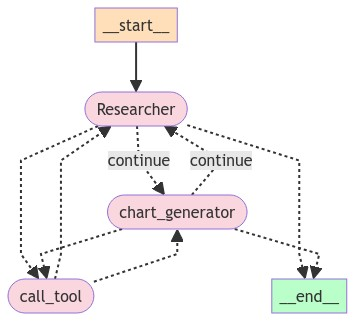

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [30]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the India's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 20},
)
for s in events:
    print(s)
    print("----")

------>>>result   content='' additional_kwargs={'tool_calls': [{'id': 'call_WUUZPWGl7plCh0S5c4Uolduc', 'function': {'arguments': '{"query":"India GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 221, 'total_tokens': 246}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-01ca074a-3a55-4b81-8cf6-1fbfec9b3660-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'India GDP over the past 5 years'}, 'id': 'call_WUUZPWGl7plCh0S5c4Uolduc'}]
last_message 


content='' additional_kwargs={'tool_calls': [{'id': 'call_WUUZPWGl7plCh0S5c4Uolduc', 'function': {'arguments': '{"query":"India GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 221, 'total_tokens': 246}, 'model_name': 'gpt-

KeyError: 'chart_generator'